# Audio key estimation of digital music with CNNs
Udacity Machine Learning Nanodegree - Capstone project

---

## Table of Contents

The project is structured as stated in section 'Project Design' of the Capstone project proposal.

_
<pre>
<a href='#Data-Preprocessing'>Data Preprocessing</a>
  <a href='#Million-Song-Dataset'>Million Song Dataset</a> - selection of appropriate songs, separate jupyter notebook
  <a href='#Signal-Processing-and-Feature-Extraction'>Signal Processing and Feature Extraction</a> - separate jupyter notebook

<a href='#Model-Preparation'>Model Preparation</a>
  <a href='#Load-and-preprocess-data'>Load and preprocess data</a> - read spectrogram images, conversion to tensors
  <a href='#Split-data-into-train-and-test-set'>Splitting data into training/testing sets</a>
  <a href='#Model-architecture'>CNN model architecture</a>
  <a href='#Model-parameter'>CNN model parameter</a>

<a href='#Model-Training-and-Evaluation'>Model Training and Evaluation</a>
  <a href='#Model-training'>Model training</a>
  <a href='#Model-evaluation-and-comparison'>Model evaluation and comparison</a>
</pre>

Current version of the project is working, but

the project is still ongoing...

discussion and remarks of what to do can be found in section

<a href='#reasons-/-todo'>reasons / todo</a>

## Data Preprocessing
---

### Million Song Dataset
- utilized to select appropriate song samples
- holds information about key and mode per song (targets)

Juypter Notebook <a href='./00.hlp/msd/msd.ipynb'>msd</a>

outputs: csv file *songs_conf=75_tracks_filt.csv*, which holds all songs with key confidence and mode confidence > 0.75

In [ ]:
# LIST SELECTED SONGS
import os
import pandas as pd
from IPython.display import display

selsongsfile = os.path.join ('00.hlp', 'msd', 'songs_conf=75_tracks_filt.csv')
selsongs = pd.read_csv (selsongsfile, header=0, index_col=0)
display (selsongs.head (1))
print ('[i] number of records:', len (selsongs))

In [ ]:
# LOAD AUDIO DATASET
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_audio')
load_content = False
description = ['Cm', 'C', 'C#m', 'C#',
               'Dm', 'D', 'D#m', 'D#',
               'Em', 'E',
               'Fm', 'F', 'F#m', 'F#',
               'Gm', 'G', 'G#m', 'G#',
               'Am', 'A', 'A#m', 'A#',
               'Bm', 'B']

src_audio_data = datasets.load_files (container_path=container_path,
                                      description=description,
                                      load_content=load_content,
                                      random_state=PARAM_RND_STATE)

In [ ]:
# FYI: LIST SOME OF THE USED SONGS
filenames = list (os.path.basename (filepath) for filepath in src_audio_data['filenames'])
usedsongs_track_id = list (os.path.splitext (fn)[0] for fn in filenames)
usedsongs = selsongs.query ('track_id in @usedsongs_track_id')

display (usedsongs.sample(5))
print ('[i] number of records:', len (usedsongs))
print ('[i] min of: key_confidence =', usedsongs['key_confidence'].min (), ',', \
       'mode_confidence =', usedsongs['mode_confidence'].min ())
print ('[i] tempo: min =', usedsongs['tempo'].min (), ',', \
       'max =', usedsongs['tempo'].max ())

In [ ]:
# ----- save list of used songs
usedsongs.to_csv ('usedsongs.csv')

In [ ]:
# ----- save list of unused songs
unusedsongs = selsongs.drop ((usedsongs.index.values))
unusedsongs.to_csv ('unusedsongs.csv')

### Signal Processing and Feature Extraction
- create spectrograms of audio files with discrete Fourier transform (DFT)
- save spectrograms as images for further use in CNN

Juypter Notebook <a href='./00.hlp/fft/fft.ipynb'>fft</a>

ouptuts: spectrograms (png images) of audio files with same folder structure as *src_audio* in new container path named *src_spectro*

**Example of a spectrogram image**

<img src ='./src_spectro/7-0/TREDRTV12903D03829.png' align=left>

## Model Preparation
---

### Load and preprocess data

### Data Preprocessing
Since there aren't enough samples to proper train the classifier, image augmentation is used.

Below jupyter notebook does the work.

Juypter Notebook <a href='./00.hlp/trnsp/trnsp.ipynb'>transposing songs</a>

In [1]:
# LOAD SPECTROGRAM FILENAMES
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_spectro')
load_content = False
description = ['Cm', 'C', 'C#m', 'C#',
               'Dm', 'D', 'D#m', 'D#',
               'Em', 'E',
               'Fm', 'F', 'F#m', 'F#',
               'Gm', 'G', 'G#m', 'G#',
               'Am', 'A', 'A#m', 'A#',
               'Bm', 'B']

src_spectro_data = datasets.load_files (container_path=container_path,
                                        description=description,
                                        load_content=load_content,
                                        random_state=PARAM_RND_STATE)
src_spectro_data.keys ()

dict_keys(['filenames', 'target_names', 'DESCR', 'target'])

In [2]:
print ('[i] example of loaded spectrogram file data:')
print ('    spectrogram image name:', src_spectro_data['filenames'][0])
print ('    spectrogram image key-mode pair:',\
       src_spectro_data['target_names'][src_spectro_data['target'][0]],\
       '=', src_spectro_data['DESCR'][src_spectro_data['target'][0]],\
       '= target class', src_spectro_data['target'][0])

[i] example of loaded spectrogram file data:
    spectrogram image name: src_spectro/2-0/TREFDWU128F9303DF8.png
    spectrogram image key-mode pair: 2-0 = Em = target class 8


**Read in images, convert to tensors**

Keras Conv2D layers expect a **4D tensor with shape (batch, rows, cols, channels)** (if param data_format='channels_last') (src: <a href='https://keras.io/layers/convolutional/#conv2d'>Keras Conv2D</a>)

In [3]:
# open a random image and take a look at the attributes
import numpy as np
from PIL import Image

im = Image.open (src_spectro_data['filenames'][0])
print ('[i] image size:', im.size)
print ('[i] pixel format:', im.mode)

[i] image size: (150, 128)
[i] pixel format: RGB


**Changing target size of image**

CNNs work best if input size is divisible by 2 many times - image size needs to be changed. (<a href='http://cs231n.github.io/convolutional-networks/#layersizepat'>cs231n - Layer Sizing Patterns</a>)

Current image size is 150 x 128: possible options
- (-) cut down the image to 128 x 128: information loss in song length
- (-) resize to 150 x 150: not divisible by 2 many times (exactly 1 time)
- (+) resize to 160 x 160: divisible by 2 many times (exactly 5 times, this is enough)

Resizing is done by appending zeros.

In [4]:
import numpy as np

PARAM_TARGET_SIZE = 160
def resize_image (img_arr):
    #print ('>>> resizing image to [{}, {}]...'.format (PARAM_IMG_SIZE, PARAM_IMG_SIZE), end=' ', flush=True)
    
    m = img_arr.shape[0]
    n = img_arr.shape[1]
    
    # how many additional cols to add?
    cols_to_add = PARAM_TARGET_SIZE - n
    
    img_resized = np.empty ((1, PARAM_TARGET_SIZE))
    for i in range (m):
        new_line = np.append (img_arr[i], np.zeros (cols_to_add))
        img_resized = np.vstack ((img_resized, new_line))
    
    img_resized = img_resized[1:]
    # now img_resized = (128, 160)
    
    # how many additional rows to add?
    rows_to_add = PARAM_TARGET_SIZE - m
    img_resized = np.vstack ((img_resized, np.zeros ((rows_to_add, PARAM_TARGET_SIZE))))
    # now img_resize = (160, 160)
    
    #print ('done')
    
    return img_resized

**Feature scaling by feature standardization**

$x^{'}= \frac{x-\bar{x}}{\sigma}$

tensorflow function used to do this

Below functions read the images and convert those to tensors - original code taken from Udacity MLND dog-project

In [5]:
from keras.preprocessing import image
from keras import backend as K
import tensorflow as tf
from tqdm import tqdm

def path_to_tensor (img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img (img_path, color_mode='grayscale')
    
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array (img)
    x = resize_image (x)
    x = x[:,:,np.newaxis]
    
    # feature standardization to zero mean and stdev of one
    # [2018-09-04] turned out that standardization prevents good learning progress
    #x = K.eval (tf.image.per_image_standardization (x))
    
    # convert 3D tensor to 4D tensor
    return np.expand_dims (x, axis=0)

def paths_to_tensor (img_paths):
    list_of_tensors = [path_to_tensor (img_path) for img_path in tqdm (img_paths)]
    return np.vstack (list_of_tensors)

Using TensorFlow backend.


In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

spectro_tensors = paths_to_tensor (src_spectro_data['filenames'])

100%|██████████| 936/936 [02:08<00:00,  7.30it/s]


In [7]:
print ('[i] shape of spectrogram tensors:', spectro_tensors.shape)

[i] shape of spectrogram tensors: (936, 160, 160, 1)


In [8]:
from keras.utils import np_utils
targets = np_utils.to_categorical (np.array (src_spectro_data['target']), 24)
print ('[i] number of output classes:', targets.shape[1])

[i] number of output classes: 24


### Split data into train and test set
[2018-09-03] obsolete since test data is in separate directory now

In [9]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = \
#    train_test_split (spectro_tensors, targets, test_size=(8/39), shuffle=True, random_state=PARAM_RND_STATE)

#print ('[i] Training dataset consists of {} samples'.format (X_train.shape[0]))
#print ('[i] Testing dataset consists of {} samples'.format (X_test.shape[0]))

X_train = spectro_tensors
y_train = targets
print ('[i] Training dataset consists of {} samples'.format (X_train.shape[0]))

[i] Training dataset consists of 936 samples


### Model architecture

(<a href='http://cs231n.github.io/convolutional-networks/#layersizepat'>cs231n - Layer Sizing Patterns</a>)

In [10]:
from keras import layers, models, regularizers
from keras import backend as K

# clear everything known of past instances ("useful to avoid clutter from old models / layers")
K.clear_session ()

# input layer
inputs = layers.Input (shape=spectro_tensors.shape[1:], name='input')

# hidden layers
net = layers.Conv2D (filters=32, kernel_size=(2,2), strides=(1,1),
                     padding='same', # don't lose information due to conv window runs out of image / strides = 1 = OK
                     activation='relu',
                     name='conv2d_1') (inputs)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_1') (net)

net = layers.Conv2D (filters=64, kernel_size=(2,2), strides=(1,1),
              padding='same',
              activation='relu',
              kernel_regularizer=regularizers.l2 (0.04),
              name='conv2d_2') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_2') (net)

net = layers.Conv2D (filters=128, kernel_size=(2,2), strides=(1,1),
              padding='same',
              activation='relu',
              kernel_regularizer=regularizers.l2 (0.04), # [2018-09-04] L2 reg to prevent overfitting
              name='conv2d_3') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='maxp_3') (net)

net = layers.Dropout (0.2, seed=PARAM_RND_STATE) (net) # [2018-09-04] dropout to prevent overfitting

# 'flatten layer'
net = layers.GlobalAveragePooling2D (name='avg_flatten') (net)

# output layer
outputs = layers.Dense (units=targets.shape[1], activation='softmax', name='output') (net)


model = models.Model (inputs=inputs, outputs=outputs)
model.summary ()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 32)      160       
_________________________________________________________________
maxp_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        8256      
_________________________________________________________________
maxp_2 (MaxPooling2D)        (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 128)       32896     
_________________________________________________________________
maxp_3 (MaxPooling2D)        (None, 20, 20, 128)       0         
__________

### Model parameter
(metric, loss function)

In [11]:
# from: Arseny Kravchenko http://arseny.info/2017/f-beta-score-for-keras.html
from keras import backend as K

PARAM_BETA = 1
def fbeta (y_true, y_pred):

    # just in case of hipster activation at the final layer
    y_pred = K.clip (y_pred, 0, 1)

    tp = K.sum (K.round (y_true * y_pred)) + K.epsilon ()
    fp = K.sum (K.round (K.clip (y_pred - y_true, 0, 1)))
    fn = K.sum (K.round (K.clip (y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = PARAM_BETA ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall)

In [12]:
from keras import optimizers, losses

PARAM_LR = 0.01 # [2018-09-04] old value = 0.001
opt_sgd = optimizers.SGD (lr=PARAM_LR, momentum=0.8)

loss = losses.categorical_crossentropy

model.compile (optimizer=opt_sgd, loss=loss, metrics=[fbeta])

## Model Training and Evaluation
---

### Model training

In [37]:
import os
from keras import callbacks

PARAM_MAX_EPOCHS = 1000 # PARAM: number of model-fit runs
#PARAM_MAX_EPOCHS = 100 # second run after 500 epochs
PARAM_N_BATCH = 64 # [2018-09-04] old value = 20 # PARAM: number of input samples for one feedfwd-backprop step

checkpointer = callbacks.ModelCheckpoint (
    filepath=os.path.join ('model','model.w.best.h5'),
    verbose=1,
    save_best_only=True)

history = model.fit (X_train, y_train,
                     epochs=PARAM_MAX_EPOCHS, batch_size=PARAM_N_BATCH, validation_split=(7/39), shuffle=True,
                     callbacks=[checkpointer], verbose=1)

Train on 768 samples, validate on 168 samples
Epoch 1/100
768/768 [==============================] - 33s 43ms/step - loss: 1.3688 - fbeta: 0.7132 - val_loss: 2.7305 - val_fbeta: 0.4772

Epoch 00001: val_loss improved from inf to 2.73051, saving model to model/model.w.best.h5
Epoch 2/100
768/768 [==============================] - 33s 43ms/step - loss: 1.5240 - fbeta: 0.6907 - val_loss: 1.9820 - val_fbeta: 0.5777

Epoch 00002: val_loss improved from 2.73051 to 1.98205, saving model to model/model.w.best.h5
Epoch 3/100
768/768 [==============================] - 33s 43ms/step - loss: 1.1935 - fbeta: 0.7774 - val_loss: 1.8349 - val_fbeta: 0.6610

Epoch 00003: val_loss improved from 1.98205 to 1.83490, saving model to model/model.w.best.h5
Epoch 4/100
768/768 [==============================] - 33s 43ms/step - loss: 1.2218 - fbeta: 0.7748 - val_loss: 2.4944 - val_fbeta: 0.4519

Epoch 00004: val_loss did not improve from 1.83490
Epoch 5/100
768/768 [==============================] - 33s 43ms/s

768/768 [==============================] - 33s 43ms/step - loss: 1.2723 - fbeta: 0.7629 - val_loss: 2.2684 - val_fbeta: 0.6070

Epoch 00043: val_loss did not improve from 1.83490
Epoch 44/100
768/768 [==============================] - 33s 43ms/step - loss: 1.3108 - fbeta: 0.7561 - val_loss: 2.1612 - val_fbeta: 0.6161

Epoch 00044: val_loss did not improve from 1.83490
Epoch 45/100
768/768 [==============================] - 33s 43ms/step - loss: 1.1332 - fbeta: 0.8196 - val_loss: 1.9205 - val_fbeta: 0.5797

Epoch 00045: val_loss did not improve from 1.83490
Epoch 46/100
768/768 [==============================] - 33s 43ms/step - loss: 1.3493 - fbeta: 0.7332 - val_loss: 2.4892 - val_fbeta: 0.4943

Epoch 00046: val_loss did not improve from 1.83490
Epoch 47/100
768/768 [==============================] - 33s 43ms/step - loss: 1.3900 - fbeta: 0.7120 - val_loss: 2.2404 - val_fbeta: 0.5637

Epoch 00047: val_loss did not improve from 1.83490
Epoch 48/100
768/768 [==============================]


Epoch 00085: val_loss did not improve from 1.68325
Epoch 86/100
768/768 [==============================] - 33s 43ms/step - loss: 1.2069 - fbeta: 0.7848 - val_loss: 2.4828 - val_fbeta: 0.5685

Epoch 00086: val_loss did not improve from 1.68325
Epoch 87/100
768/768 [==============================] - 33s 43ms/step - loss: 1.6094 - fbeta: 0.6613 - val_loss: 3.2706 - val_fbeta: 0.4200

Epoch 00087: val_loss did not improve from 1.68325
Epoch 88/100
768/768 [==============================] - 33s 43ms/step - loss: 1.8800 - fbeta: 0.5869 - val_loss: 2.5402 - val_fbeta: 0.4416

Epoch 00088: val_loss did not improve from 1.68325
Epoch 89/100
768/768 [==============================] - 33s 43ms/step - loss: 1.6002 - fbeta: 0.6500 - val_loss: 2.3038 - val_fbeta: 0.5091

Epoch 00089: val_loss did not improve from 1.68325
Epoch 90/100
768/768 [==============================] - 33s 43ms/step - loss: 1.3683 - fbeta: 0.7330 - val_loss: 2.0583 - val_fbeta: 0.6083

Epoch 00090: val_loss did not improve f

### Model evaluation and comparison

In [38]:
print (history.history.keys())

dict_keys(['val_loss', 'fbeta', 'val_fbeta', 'loss'])


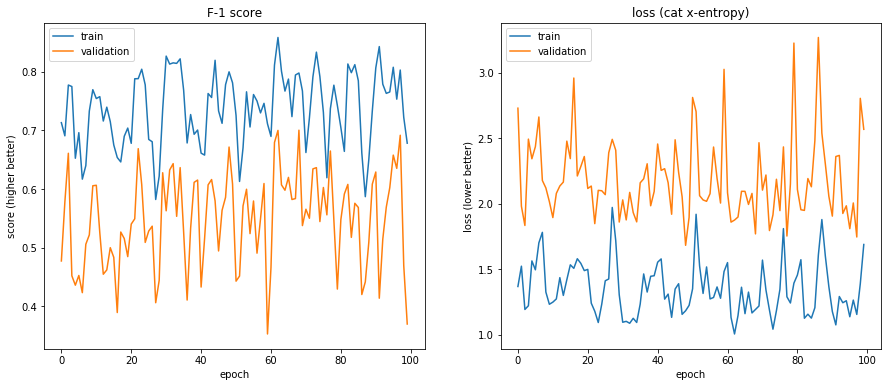

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots (1, 2)

# summarize history for accuracy
axs[0].plot (history.history['fbeta'])
if 'val_fbeta' in history.history:
    axs[0].plot (history.history['val_fbeta'])
axs[0].set (xlabel='epoch', ylabel='score (higher better)', title='F-{} score'.format (PARAM_BETA))
axs[0].legend (['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot (history.history['loss'])
if 'val_loss' in history.history:
    axs[1].plot (history.history['val_loss'])
axs[1].set (xlabel='epoch', ylabel='loss (lower better)', title='loss (cat x-entropy)')
axs[1].legend (['train', 'validation'], loc='upper left')

fig.set_size_inches ((15., 6.), forward=True)
plt.show ()

**discussion**

[2018-09-02]

epoch 205:
- loss: 0.0280
- val_loss: 0.4546
- fbeta: 1.0000
- val_fbeta: 0.9412

_

Above graphs show the F-beta score per epoch with beta = 1 on the left and the *loss per epoch*, calulated by the mean squared error (mse) on the right.

*loss per epoch*:
- gradient steps start with a loss of 0.052, end by 0.042 and show a smooth concave curve. The curve couldn't be better except a faster drop in the first 10 epochs.
- the worse: mse after 1st epoch = 0.052 - the CNN learns very slow and in tiny steps (1st/2nd epoch: 0.052-0.049 = 0.003)

*F-beta score per epoch*
- evaluation metric immediately drops to zero after some epochs - the CNN doesn't learn anything yet

#### reasons / todo

*input data*

(1) The used dataset only has 240 samples for training, validation and test. This is by far nothing for the CNN.

Todo: retrieve more samples for the dataset

(2) A quick look at random spectrograms show kind of chaotic information - as a human being it is hard to tell if there's any structure behind each key-mode pair. This may apply to the CNN too.

Todo: find additional filter techniques / methods to clearly bring out structures for the CNN

(3) Songs can change in key over their whole length.

Todo: take appropriate sample of a song - ommit bridges, refrains, silent passages, noisy songs

_

*model training*

The model was trained for 100 epochs, each in batches of 10 samples per feedfwd-backprop step. To make sure that the architecture is well suited, more epochs shall be run.

Todo: increase epochs, change batch size

_

*model architecture*

Todo: To better understand the insight of the CNN, visualize the filter of the convolutions. May there be enlightenment what kind of architecture works best.

#### compare learning algorithm to benchmarks

[i] below statements can be run without executing the whole notebook

Therefor, go to and execute <a href='#load-learning-algorithm'>load learning algorithm</a>

**TODO** **TODO** **TODO**

**benchmark data - fft**

Juypter Notebook <a href='./00.hlp/fft/fft.ipynb#Benchmark-data'>benchmark data - fft</a>

In [41]:
# LOAD SPECTROGRAM FILENAMES
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_bench', 'src_spectro')
load_content = False
description = ['Cm', 'C', 'C#m', 'C#',
               'Dm', 'D', 'D#m', 'D#',
               'Em', 'E',
               'Fm', 'F', 'F#m', 'F#',
               'Gm', 'G', 'G#m', 'G#',
               'Am', 'A', 'A#m', 'A#',
               'Bm', 'B']

src_bench_spectro_data = datasets.load_files (container_path=container_path,
                                              description=description,
                                              load_content=load_content,
                                              random_state=PARAM_RND_STATE)
src_bench_spectro_data.keys ()

dict_keys(['filenames', 'target_names', 'DESCR', 'target'])

In [42]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

bench_spectro_tensors = paths_to_tensor (src_bench_spectro_data['filenames'])

100%|██████████| 48/48 [00:02<00:00, 20.44it/s]


In [43]:
X_test = bench_spectro_tensors
y_test = np_utils.to_categorical (np.array (src_bench_spectro_data['target']), 24)

model.load_weights (os.path.join ('model','model.w.best.h5'))

score = model.evaluate (X_test, y_test, verbose=1)
print ([(model.metrics_names[i], score[i]) for i in range (len (model.metrics_names))])

48/48 [==============================] - 1s 17ms/step
[('loss', 4.7337643305460615), ('fbeta', 0.09235209971666336)]


In [44]:
# confusion matrix
import pandas as pd
from IPython.display import display
from sklearn.metrics import confusion_matrix

y_true = [y_test[i].argmax () for i in range (len (y_test))]
model_pred = model.predict (X_test)
y_pred = [model_pred[i].argmax () for i in range (len (model_pred))]

cm = confusion_matrix (y_true, y_pred)
cm_pd = pd.DataFrame (data=cm, index=src_bench_spectro_data['DESCR'], columns=src_bench_spectro_data['DESCR'])

pd.set_option ('display.max_columns', 24)
display (cm_pd)

,Cm,C,C#m,C#,Dm,D,D#m,D#,Em,E,Fm,F,F#m,F#,Gm,G,G#m,G#,Am,A,A#m,A#,Bm,B
Cm,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
C,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
C#m,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
C#,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
Dm,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
D#m,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
D#,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
Em,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


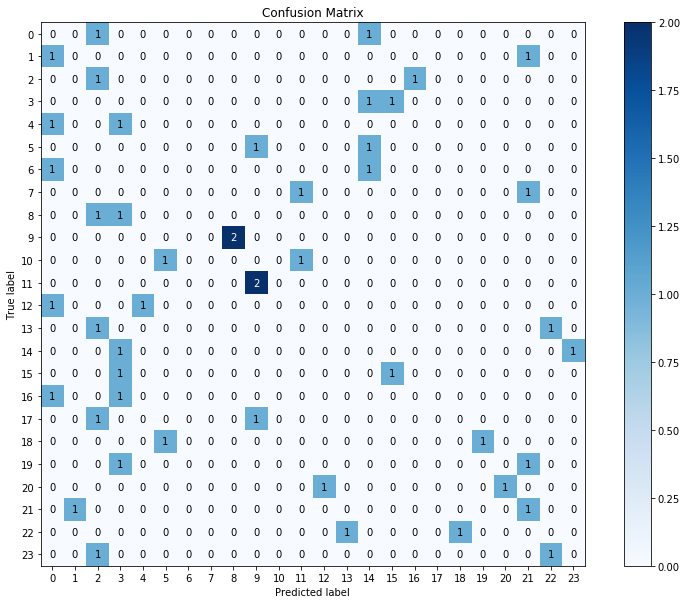

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix (y_true, y_pred, figsize=(14,10));

## Misc
---

### save learning algorithm

In [40]:
# serialization of model architecture
import os
import time
import pandas as pd

t = time.strftime ("%Y%m%d-%H%M%S", time.gmtime ())

# save model architecture
save_name = os.path.join ('model', t + '_model.arch' + '.yaml')
print ('>>> saving model architecture...', end=' ', flush=True)
yaml_string = model.to_yaml ()
with open (save_name, 'w') as yaml_file:
    yaml_file.write (yaml_string)
print ('done')

# save model weights
save_name = os.path.join ('model', t + '_model.weights' + '.h5')
print ('>>> saving model weights...', end=' ', flush=True)
model.save_weights (save_name)
print ('done')

# save learning history
save_name = os.path.join ('model', t + '_model.hist' + '.csv')
print ('>>> saving model history...', end=' ', flush=True)
hist_df = pd.DataFrame.from_dict (history.history)
hist_df.to_csv (save_name)
print ('done')

>>> saving model architecture... done
>>> saving model weights... done
>>> saving model history... done


### load learning algorithm

In [ ]:
# load model architecture
import os
from keras import models

load_name = os.path.join ('model', 'model.arch.yaml')
print ('>>> loading and compiling model...', end=' ', flush=True)
with open (load_name, 'r') as yaml_file:
    yaml_string = yaml_file.read ()
model = models.model_from_yaml (yaml_string)
model.compile (optimizer=opt_sgd, loss=losses.mean_squared_error, metrics=[fbeta])
print ('done')

# load best weights
print ('>>> loading best weights into model...', end=' ', flush=True)
model.load_weights (os.path.join ('model','model.w.best.h5'))
print ('done')

In [ ]:
idx = 42
test_file = src_spectro_data['filenames'][idx]

test_spectro = path_to_tensor (test_file)
test_pred = model.predict (test_spectro)

print (test_file)
print ('y_true', src_spectro_data['target_names'][src_spectro_data['target'][idx]])
print ('y_pred', src_spectro_data['target_names'][test_pred.argmax ()])

## Obsolete

**drawbacks** (known, unresolvable issues)

(WRONG) *music keys vs CNN key classes*

See <a href='https://www.researchgate.net/publication/228963946_Audio_onset_detection_using_machine_learning_techniques_the_effect_and_applicability_of_key_and_tempo_information'>Chuan, Ching-Hua & Chew, Elaine. (2018). Audio onset detection using machine learning techniques: the effect and applicability of key and tempo information.</a>, p. 18

The spectrograms show a pitch range given by the <a href='https://en.wikipedia.org/wiki/Scientific_pitch_notation#Table_of_note_frequencies'>Scientific Pitch Notation</a>. By that the range of notes goes from $C_{-1}$ = $0_{MIDI}$ up to $G_9$ = $127_{MIDI}$.

Each note can be the tonic of a music key - for example the key 'C major' exists 11 times (ocatve -1 to 9). Thus the information of 128 keys is now squeezed into 24 key classes.

...